In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

import pandas as pd 
pd.set_option('display.max_colwidth', -1)
import sklearn
from sklearn import base
import spacy
import re
import numpy as np

from pprint import pprint as pp
from itertools import combinations

# State Jail Data

The data was pulled from the **Recidiviz** BigQuery database using the following query statement, modifying the WHERE statement as necessary to get the truth or missing data for a given state:


SELECT name, class, region FROM `recidiviz-123.census.charge` as charge <br>
LEFT JOIN `recidiviz-123.census.booking` as booking ON charge.booking_id = booking.booking_id <br>
LEFT JOIN `recidiviz-123.census.person` as person ON booking.person_id = person.person_id <br>
WHERE class IS NOT NULL AND region LIKE "us_ky%" <br>
ORDER BY region <br>


The data has the following columns: name (str), class (str), region (str). <br>

The region was kept for possible regional statistics if need be, but is not currently used to train the charge classifier (which is built on the state level)


In [79]:
charge_data_no_class = pd.read_csv(r"/Users/jmart/Documents/recidiviz_data/06_13_19_ky_missing.csv")

charge_data = pd.read_csv(r"/Users/jmart/Documents/recidiviz_data/06_13_19_ky_truth.csv")
charge_data.head()

,name,class,region
0,SERVING BENCH WARRANT FOR COURT,PROBATION_VIOLATION,us_ky_adair
1,SERVING BENCH WARRANT FOR COURT,PROBATION_VIOLATION,us_ky_adair
2,SERVING BENCH WARRANT FOR COURT,PROBATION_VIOLATION,us_ky_adair
3,SERVING BENCH WARRANT FOR COURT,PROBATION_VIOLATION,us_ky_adair
4,SPEEDING 15 MPH OVER LIMIT,MISDEMEANOR,us_ky_adair


# Organize Data

In [80]:
from sklearn.model_selection import train_test_split

### count nan values per column and drop all rows with nan values
print("NaN counts per column:")
print(charge_data.isna().sum())
print("Dropping NaN's from data if they exist...")
charge_data.dropna(inplace=True)
print("Should be no NaN's left:")
print(charge_data.isna().sum())

### Will assume charge descriptions indepedent of region (FOR NOW)
charge_desc = charge_data.drop(['class', 'region'], axis=1).values
charge_class = charge_data['class'].values

NaN counts per column:
name      3
class     0
region    0
dtype: int64
Dropping NaN's from data if they exist...
Should be no NaN's left:
name      0
class     0
region    0
dtype: int64


# Charge Classifer

The **charge classifier** takes in a **charge description** and outputs a **charge class**

                  
i.e. In the state KY: **charge description** = "PUBLIC INTOXICATION-CONTROL SUB (EXCLUDES ALCOHOL)" --> **charge class** = MISDEMEANOR

> The ML model will take place in two steps:
1. NLP to vectorize the words in each charge description
2. ML classifier to take vectorized words as input and classify the charge description

**The charge classifier will be trained per state due to differences in the law:**
1. The possible charges can differ from state to state
2. The descriptions of the charges themselves (even equivalent ones) may vary
3. The charge classes will likely be different from state to state:
    * i.e. felony charge classes: https://www.criminaldefenselawyer.com/resources/criminal-defense/felony-offense/felony-classes-charges-penalties

### Charge Classifier Model Diagram

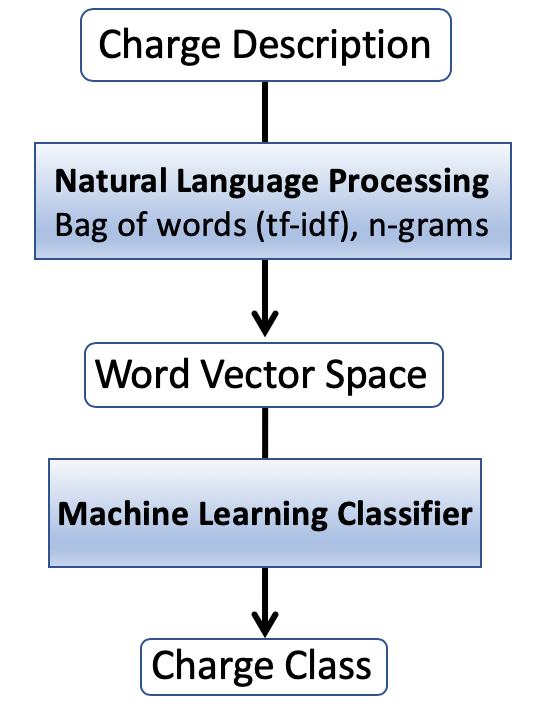

In [5]:
from IPython.display import Image
from IPython.core.display import HTML 
Image("images/charge_classifier_model.png", width=240, height=240)

### Example of the charge classifier

Here we are given a human entered textual input, in this case for a drunk driving case in KY. In this specific case for a 1st offense, it is classified as a Misdemeanor in KY. 

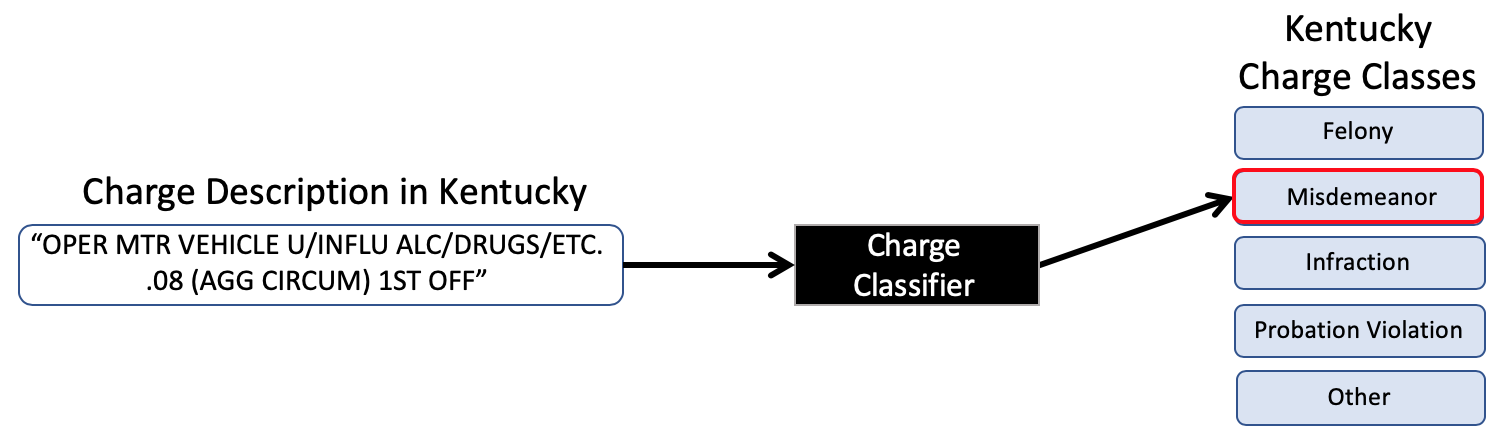

In [6]:
Image("images/charge_classifer_example.png", width=800, height=600)

### Imbalanced Classification Problem

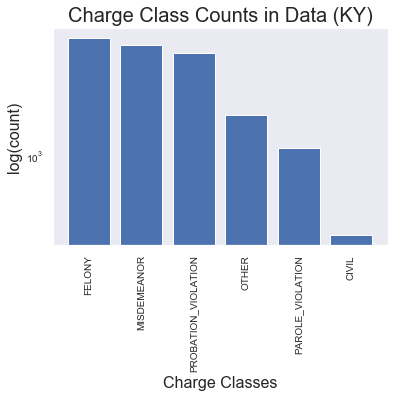

In [7]:
class_cnt_dict = charge_data['class'].value_counts().to_dict()
(x, y) = zip(*class_cnt_dict.items())
plt.bar(x,y)
plt.grid(b=None)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.yscale('log')
plt.title('Charge Class Counts in Data (KY)', fontsize=20)
plt.xlabel('Charge Classes', fontsize=16)
plt.ylabel('log(count)', fontsize=16)
plt.grid(False)

Given that the database is growing in real time, we do not need to use methods such as SMOTE to syntheically increase data points for less represented classes. Instead we can re-run analysis at a future point when more data is available and toss values from the larger classes to balance the data set, if need be. 

**This has not been done up to this point.** Balancing the dataset would make metrics such as accuracy more relevant, but we can use alternative metrics (precision, recall, sensitivity) to judge the performance of the charge classifier. 

## Motivation: Completeness if Jails Data

**Found using the following query:**

SELECT pc.region, IFNULL(pc.cnt_has_charge_class,0) as cnt_has_charge_class, IFNULL(nc.cnt_null_charge_class,0) as cnt_null_charge_class, 
(IFNULL(pc.cnt_has_charge_class,0)+IFNULL(nc.cnt_null_charge_class,0)) as total_charges, 
1.0*IFNULL(pc.cnt_has_charge_class,0)/(IFNULL(pc.cnt_has_charge_class,0)+IFNULL(nc.cnt_null_charge_class,0)) as percent_filled

FROM

(SELECT region, COUNT(*) as cnt_has_charge_class FROM `recidiviz-123.census.charge` as charge
LEFT JOIN `recidiviz-123.census.booking` as booking ON charge.booking_id = booking.booking_id
LEFT JOIN `recidiviz-123.census.person` as person ON booking.person_id = person.person_id
WHERE class IS NOT NULL AND region LIKE "us_ky%"
GROUP BY region) as pc

LEFT OUTER JOIN (SELECT region, COUNT(*) as cnt_null_charge_class FROM `recidiviz-123.census.charge` as charge
LEFT JOIN `recidiviz-123.census.booking` as booking ON charge.booking_id = booking.booking_id
LEFT JOIN `recidiviz-123.census.person` as person ON booking.person_id = person.person_id
WHERE class IS NULL AND region LIKE "us_ky%"
GROUP BY region) as nc ON pc.region = nc.region

ORDER BY percent_filled DESC

In [109]:
state_stats = pd.read_csv(r"/Users/jmart/Documents/recidiviz_data/06_12_19_database_completeness_by_state.csv")
state_stats

,state,num_filled_charge_classes,num_null_charge_classes,total_charges,percent_has_charge_class
0,wy,17,185,202,0.084158
1,pa,486,64,550,0.883636
2,ks,171,755,926,0.184665
3,la,101,1207,1308,0.077217
4,ms,229,1814,2043,0.112090
5,mt,270,1931,2201,0.122672
6,ok,8,2441,2449,0.003267
7,co,4671,695,5366,0.870481
8,ca,5459,50,5509,0.990924
9,nj,127,5647,5774,0.021995


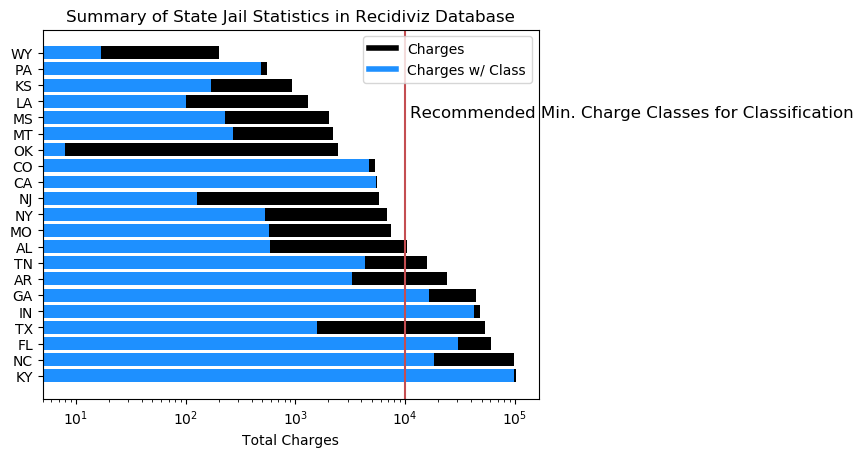

In [110]:
plt.rcdefaults()
fig, ax = plt.subplots()

states = state_stats['state'].values
states = [x.upper() for x in states]
y_pos = np.arange(len(states))
total_charges = state_stats['total_charges'].values
num_cc = state_stats['num_filled_charge_classes'].values

data = [(st, t, cc) for (st, t, cc) in zip(states, total_charges, num_cc)]
data = sorted(data, key = lambda x: x[1])

labels = [st for (st,t,cc) in data]
y1 = [t for (st,t,cc) in data]
y2 = [cc for (st,t,cc) in data]

lo_lim = 0
hi_lim = len(labels)

labels = labels[lo_lim:hi_lim]
y1 = y1[lo_lim:hi_lim]
y2 = y2[lo_lim:hi_lim]
y_pos = y_pos[lo_lim:hi_lim]

ax.barh(y_pos, y1, align='center',
        color='black')
ax.barh(y_pos, y2, align='center',
        color='dodgerblue')
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Total Charges')
ax.set_title('Summary of State Jail Statistics in Recidiviz Database')
ax.set_xscale('log')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='black', lw=4),
                Line2D([0], [0], color='dodgerblue', lw=4)]

ax.legend(custom_lines, ['Charges', 'Charges w/ Class'])

plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=30)

plt.axvline(x=10000, color='r')
t = ("Recommended Min. "
     "Charge Classes "
     "for Classification")
plt.text(10000*1.1, len(labels)/5, t, fontsize=12, 
        va='bottom', rotation=0, wrap=True)

plt.show()

# plt.savefig('state_charges_comparison.png', dpi=800)

### (In)completeness of jail data

The jail data is woefully incomplete in many states, lacking charge classes for individuals admitted to prison. But we cannot wait for policies to be enacted that will hold jails across the United States to a higher standard of electronic record keeping. The goal of this project is to use ML to predict these missing charge classes, which are the basic metric by which we can quantify how US Jails operate. The United States has incarceration rates an order of magnitude larger than the majority of other countries in the world. The story of mass incarceration in the United States is in the data, and we can hope the story will be compelling enough to drive relevant end users to improve it.

### End Users

There are a number of end users who could make use of this classifier and/or the data metrics provided to analyze the US prison system.

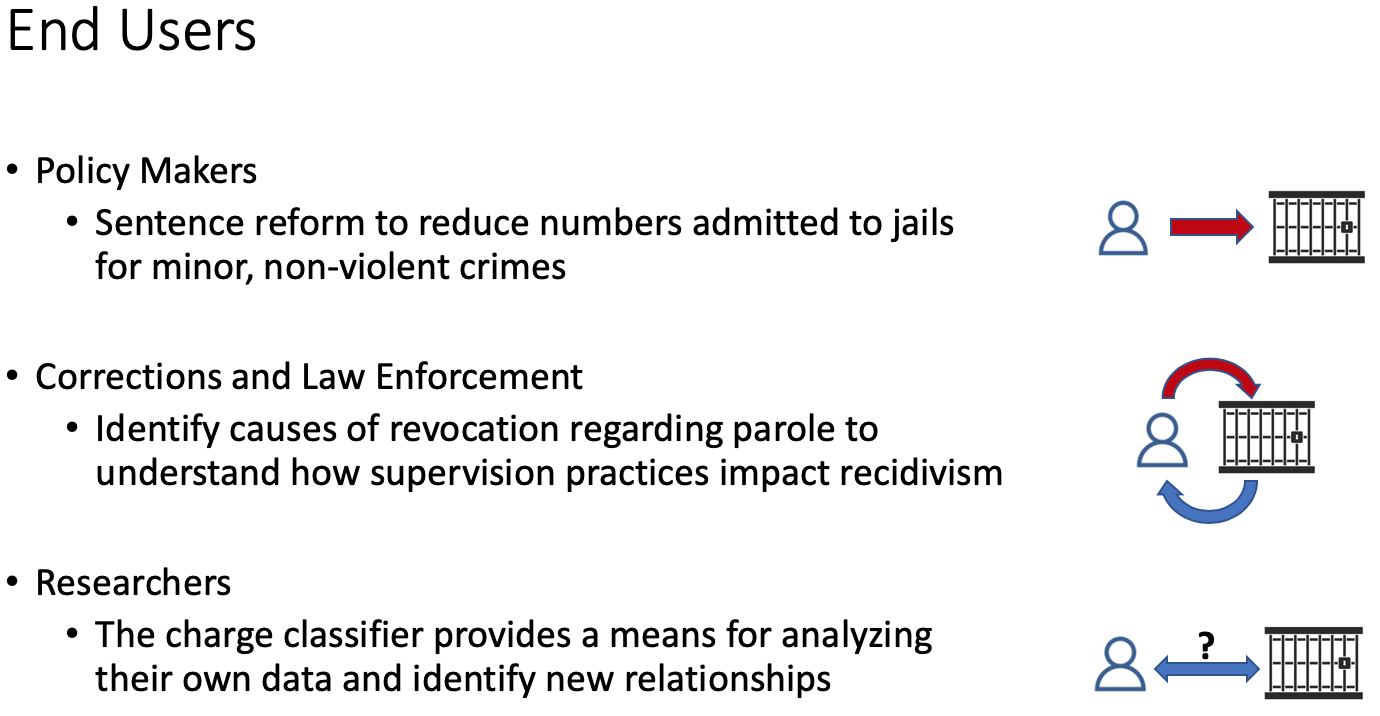

In [111]:
Image("images/end_users.png", width=800, height=600)

### Basic Statistics for Data in a Given State

In [81]:
print("Entries WITHOUT a charge class = {}".format(len(charge_data_no_class)))
print("Entries WITH a charge class = {}".format(len(charge_data)))
print("Percentage of charges having a charge description = {}".format(float(len(charge_data))/(len(charge_data)+len(charge_data_no_class))*100))
print("")
print("Number of unique charge classes: " + str(len(np.unique(charge_data['class']))))
print("Charge Classes = " + ', '.join(np.unique(charge_data['class'])))
print("")
print("Number of unique charge descriptions: " + str(len(np.unique(charge_data['name']))))


Entries WITHOUT a charge class = 4147
Entries WITH a charge class = 98774
Percentage of charges having a charge description = 95.97069597069597

Number of unique charge classes: 6
Charge Classes = FELONY, INFRACTION, MISDEMEANOR, OTHER, PAROLE_VIOLATION, PROBATION_VIOLATION

Number of unique charge descriptions: 2654


## Training Charge Classifier Model(s)

In [82]:
## cd = charge description
## cc = charge class

### Divide data into train and test (train:80%, test:20%)
cd_train, cd_test, cc_train, cc_test = train_test_split(charge_desc, charge_class, test_size=0.20, random_state=42)

print()
print("cd_train shape = {}".format(cd_train.shape))
print("cc_train shape = {}".format(cc_train.shape))
print()
print("cd_test shape = {}".format(cd_test.shape))
print("cc_test shape = {}".format(cc_test.shape))


cd_train shape = (79019, 1)
cc_train shape = (79019,)

cd_test shape = (19755, 1)
cc_test shape = (19755,)


# 1. Natural Language Processing

First step in the ML model is to vectorize the words in each charge description, required for later ML classification approaches.

**NLP Techniques (word vectorizing):**

> **Bag of Words (Primary approach)**
- Directly applicable to transforming text charge descriptions into a matrix with rows (each charge description) and columns (features). This matrix counts the number of occurances of each feature in a given charge description.


> **Word2Vec (Secondary approach...Not applied here)**
- Gives relations between words (i.e. 'King' - 'Man' + 'Woman' = 'Queen')...Best when one has a large corpus of text to train on (unlike our individual charge descriptions) or a pre-trained model on language for a given field of interest. Possibly applicable here, but will require careful thought and implementation.

**Text Filtering/Parsing Methods:**

> **Handle Typos**:
- missing letters and spaces
    - Original: PUBLIC INTOXICATION-**CONTROLL** SU**B(E**XCLUDES ALCOHOL)	MISDEMEANOR
    - Clean:    PUBLIC INTOXICATION-**CONTROL** SUB (EXCLUDES ALCOHOL)	MISDEMEANOR
    - ...
    - **Strategies:**
        - Ignore typos initially
        - Use known packages to handle typos in the future

> **Handle Abbreviations**:

    - **w/ Abbreviations:** OPER MTR VEHICLE U/INFLU ALC/DRUGS/ETC. .08 (AGG CIRCUM) 1ST OFF	MISDEMEANOR
    - **w/ Expanded Text:** OPERATOR MOTOR VEHICLE UNDER/INFLUENCE ALCOHOL/DRUGS/ETC. .08 (AGGREVATING CIRCUMSTANCES) 1ST OFF	MISDEMEANOR
    - ...
    - **Strategies:**
        - Ignore and observe classifer efficiency
        - Scrape "Kentucky Legal Handbook for Patrol" and replace each abbreviation with full text
        - dict[abbr] = word(s)
        
> **Impact of both Typos/Abbreviations**
- Erroneously increases the number of unique charges descriptions and features in our Bag of Words
        
> **Excluding "Stop words":**
- **Articles:** "a", "an", "the", etc.
        
> **Selectively Removing Punctuation:**
- By default, vectorizers in sklearn ignore all punctuation...but it may be useful to keep comparison operators ("=", ">" "<") in the text. This is described later on in greater detail
- **Special case** U/\\$1,000 is used to mean "under 1000 dollars)
    - built-in tokenizer interprets "U/\\$1,000" as "1" and "000"
- The forward slash "/"
    -U/\\$1000 = under \\$1000 OR B/W = between

# Bag of Words

> Bag of Words approach will use two steps:
1. Tranform data into correct format **NumpyListofListsTransformer()**
2. Special tokenizer to take advantage of pithy syntax in charge descriptions
3. Use the TfidfVectorizer to get word counts and then normalize them

## 2. ML Classifier

> There are many ML models that can be used for the charge classifer:
1. Naive Bayes
2. Support Vector Machine (SVM)
3. Logistical Regressor

I will proceed to train/test each, starting with the most simplistic in order to achieve a MVP.

**ML MODELS TRAINED**
1. Naive Bayes
2. SVM
3. Logsitic Regression

**BEST PERFORMER:** 
1. Logistical Regression


# Misc Definitions and Global Variables

In [12]:
from collections import Counter
def hasMinChargeClasses(cc_train, cc_test, total_classes):
    ''' Used to check the frequency of charges for each charge class in a given state.
        As such, it can be used a pre-check to make sure there is enough data for training
        the models, using cross-validation technqiues'''
    
    cc_train_counts = Counter(cc_train)
    cc_test_counts = Counter(cc_test)
    
    print(cc_train_counts)
    
    ### check if all classes represented
    if len(cc_train_counts) < total_classes or len(cc_test_counts) < total_classes:
        print('1')
        return False
    
    ### check if occurances for each class larger than threshold
    threshold = 50
    for cc, cnt in cc_train_counts.items():
        if cnt < threshold:
            print('2')
            return False
        
    for cc, cnt in cc_test_counts.items():
        if cnt < threshold:
            print('3')
            return False
        
    return True
    

In [13]:
from nltk.corpus import stopwords
def getStopWords():
    '''Returns list of stop words that will not be considered in 
       NLP vectorization.
       
       List of stop words generated from common articles of speech
       and those parts of speech recognized as articles in the
       charge descriptions using Spacy'''
    
    stopWords = list(stopwords.words('english'))
    
    for i, word in enumerate(stopWords[:]):
        stopWords[i] = re.sub('[\',]', '', word)
    
    return stopWords
    

In [14]:
def getSortedVocab():
    '''Returns sorted list of features from our bag of words, sorted by 
       highest frequency of occurance across all charge descriptions'''
    nplol = NumpyListofListsTransformer()
    count_vect = CountVectorizer()

    r1 = nplol.transform(cd_train)
    count_vect.fit(r1)

    sorted_vocab = sorted(count_vect.vocabulary_.items(), key=lambda kv: kv[1])
    return sorted_vocab

## Special pre-processor and tokenzier to handle special syntax

In [18]:
import re
def my_preprocessor(s):
    s = re.sub('(\d+),(\d+)', '\g<1>\g<2>', s) ### remove commas from numbers
    s = re.sub('[/\$]', '', s) ### special case for U/$10000 syntax --> U10000
    return s.lower()

In [19]:
def get_tokenizer():
    return r"(?u)\b\w+\b"

### No special preprocessing or tokenizing

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect_single = CountVectorizer(ngram_range=(1,6), stop_words=getStopWords())

sm = count_vect_single.fit_transform(['TBUT OR DISP ALL OTHERS $500 OR MORE BUT U/$10,000'])

vocab = count_vect_single.vocabulary_
for word, index in vocab.items():
    print(word)

tbut
disp
others
500
10
000
tbut disp
disp others
others 500
500 10
10 000
tbut disp others
disp others 500
others 500 10
500 10 000
tbut disp others 500
disp others 500 10
others 500 10 000
tbut disp others 500 10
disp others 500 10 000
tbut disp others 500 10 000


### Special preprocessing or tokenizing

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect_single = CountVectorizer(ngram_range=(1,6), stop_words=getStopWords(), preprocessor=my_preprocessor, token_pattern=get_tokenizer())

sm = count_vect_single.fit_transform(['TBUT OR DISP ALL OTHERS $500 OR MORE BUT U/$10,000'])

vocab = count_vect_single.vocabulary_
for word, index in vocab.items():
    print(word)

tbut
disp
others
500
u10000
tbut disp
disp others
others 500
500 u10000
tbut disp others
disp others 500
others 500 u10000
tbut disp others 500
disp others 500 u10000
tbut disp others 500 u10000


In [22]:
class NumpyListofListsTransformer(base.BaseEstimator, base.TransformerMixin):
    ''' Transforms list of lists containing charge descriptions into a numpy
        array of arrays, keeping charge descriptions invariant'''
    
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        np_charge_descs = []
        for cd_list in X:
            for cd in cd_list:
                np_charge_descs.append(cd)       
        
        result = np.array(np_charge_descs)
        
        return result

In [23]:
def missedClassifications(charge_desc, predicted, actual):
    ''' Takes in charge descriptions, predicted charge class and
        actual charge class.
        
        Returns a pandas dataframe for all mis-classifications, where
        columns are: 'Charge Description', 'Predicted Charge Class', 'Actual Charge Class' '''
    
    incorrect = []
    for c, p, a in zip(charge_desc, predicted, actual):
        if p != a:
            incorrect.append([c[0], p, a])

    return pd.DataFrame.from_records(incorrect, columns = ['Charge Description', 'Predicted Charge Class', 'Actual Charge Class'])


In [123]:
def missedClassificationCounts(df_missed_classifications):
    '''Takes in a pandas dataframe of missed classifications.
    
       Returns the same dataframe, for each unique Charge Description,
       with an additional 'counts' column, sorted in descending order by 'counts' '''
    
#     mc_base_unique_cd_counts = df_missed_classifications.groupby(['Charge Description'])['Charge Description']\
#     .count().reset_index(name="Total Missed for Charge Description")
    
    mc_base_unique_cd_counts = df_missed_classifications\
    .groupby(['Charge Description', 'Predicted Charge Class', 'Actual Charge Class'])['Charge Description']\
    .size().reset_index(name="Total Missed for Charge Description")
    
#     df.groupby(['ColA','ColB']).size().reset_index(name='Count')

#     print(mc_base_unique_cd_counts)

    mc_base_unique_cd_counts.sort_values(['Charge Description', 'Total Missed for Charge Description'], axis=0, ascending=False, 
                               inplace=True, kind='quicksort') 

    return mc_base_unique_cd_counts

In [ ]:
def cd_charge_classes_in_data(charge_data, cd):
    
    return charge_data.loc[charge_data['name'] == cd]\
    .pivot_table(index='name', columns='class', aggfunc="count", fill_value=0)

# ---- ML MODELS ----

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Model 1 (Naive Bayes)

# Model 1: The Baseline
- No text filtering of charge descriptions
- No parameter tuning in NLP Vecotrizing
- No parameter tuning in ML Naive Bayes Classifier

In [163]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

nplol = NumpyListofListsTransformer()
count_vect = CountVectorizer(preprocessor=my_preprocessor, token_pattern=get_tokenizer())
mnb = MultinomialNB()

pipe_base = Pipeline([
        ('nplol_base', nplol),
        ('count_vect', count_vect),
        ('mnb_base', mnb),
])

nb_charge_clf_0 = pipe_base.fit(cd_train, cc_train)

predicted = pipe.predict(cd_test)
print("Accuracy = {}%".format(round(accuracy_score(cc_test, predicted, normalize=True)*100.0,2)))
print()
print(classification_report(cc_test, predicted))

# mc_base = missedClassifications(cd_test, predicted, cc_test)
# mc_base_counts = missedClassificationCounts(mc_base)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(mc_counts)

Accuracy = 98.68%

                     precision    recall  f1-score   support

             FELONY       0.99      0.99      0.99      8886
         INFRACTION       0.98      0.99      0.99      1069
        MISDEMEANOR       0.99      0.99      0.99      5850
              OTHER       0.97      0.80      0.88       338
   PAROLE_VIOLATION       0.00      0.00      0.00         1
PROBATION_VIOLATION       0.96      0.99      0.98      3611

          micro avg       0.99      0.99      0.99     19755
          macro avg       0.82      0.79      0.80     19755
       weighted avg       0.99      0.99      0.99     19755



/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Model 1a: No surprise that TF/IDF had virtually no impact
- No text filtering of charge descriptions
- **NLP Vecotrizing normalizing word count (TF/IDF)**
- No parameter tuning in ML Naive Bayes Classifier

In [86]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

nplol = NumpyListofListsTransformer()
tfidf = TfidfVectorizer(preprocessor=my_preprocessor, token_pattern=get_tokenizer())
mnb = MultinomialNB()


pipe = Pipeline([
        ('nplol', nplol),
        ('tfidf', tfidf),
        ('mnb', mnb),
])

bad_charge_clf = pipe.fit(cd_train, cc_train)

predicted = bad_charge_clf.predict(cd_test)
print("Accuracy = {}%".format(round(accuracy_score(cc_test, predicted, normalize=True)*100.0,2)))
print()
print(classification_report(cc_test, predicted))


# mc_base = missedClassifications(cd_test, predicted_based, cc_test)
# mc_base_counts = missedClassificationCounts(mc_base)
# mc_base_counts

Accuracy = 93.08%

                     precision    recall  f1-score   support

             FELONY       0.92      0.96      0.94      8886
         INFRACTION       0.95      0.94      0.94      1069
        MISDEMEANOR       0.95      0.87      0.91      5850
              OTHER       0.85      0.71      0.78       338
   PAROLE_VIOLATION       0.00      0.00      0.00         1
PROBATION_VIOLATION       0.92      0.98      0.95      3611

          micro avg       0.93      0.93      0.93     19755
          macro avg       0.77      0.74      0.75     19755
       weighted avg       0.93      0.93      0.93     19755



/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Model 1b: Including stop words seems to drop accuracy

**Likely because charge descriptions make frequent use of abbreviations and pithy language...so cutting out common words such as "and, "or","more", etc. can be ill-advised when it would be relevant to charge descriptions stating "$500 OR MORE", which can often be the difference between a felony and a misdemeanor**

- No text filtering of charge descriptions
- **NLP Vecotrizing contains generic list of "Stop Words"**
- No parameter tuning in ML Naive Bayes Classifier

In [126]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

nplol = NumpyListofListsTransformer()
tfidf = TfidfVectorizer(stop_words=getStopWords(), preprocessor=my_preprocessor, token_pattern=get_tokenizer())
mnb = MultinomialNB()

pipe_base = Pipeline([
        ('nplol_base', nplol),
        ('tfidf', tfidf),
        ('mnb_base', mnb),
])

charge_clf = pipe_base.fit(cd_train, cc_train)

predicted = charge_clf.predict(cd_test)
print("Accuracy = {}%".format(round(accuracy_score(cc_test, predicted, normalize=True)*100.0,2)))
print()
print(classification_report(cc_test, predicted))

# mc_base = missedClassifications(cd_test, predicted_based, cc_test)
# mc_base_counts = missedClassificationCounts(mc_base)
# mc_base_counts

Accuracy = 90.81%

                     precision    recall  f1-score   support

             FELONY       0.91      0.94      0.93      8886
         INFRACTION       0.91      0.99      0.95      1069
        MISDEMEANOR       0.96      0.81      0.88      5850
              OTHER       0.74      0.73      0.74       338
   PAROLE_VIOLATION       0.00      0.00      0.00         1
PROBATION_VIOLATION       0.86      0.98      0.91      3611

          micro avg       0.91      0.91      0.91     19755
          macro avg       0.73      0.74      0.73     19755
       weighted avg       0.91      0.91      0.91     19755



# Model 1c: Ngrams greatly improves model
- No text filtering of charge descriptions
- **NLP Vecotrizing using ngrams**
- No parameter tuning in ML Naive Bayes Classifier

...

1. ngram = (1,1) means only individual words are counted as features
2. ngram = (1,2) means individual words and pairs of words are counted as features
3. ngram = (2,3) means only pairs and triplets of words are counted as features
4. ...

In [128]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

nplol = NumpyListofListsTransformer()
tfidf = TfidfVectorizer(preprocessor=my_preprocessor, 
                        token_pattern=get_tokenizer(), ngram_range=(1,6))
mnb = MultinomialNB()

pipe = Pipeline([
        ('nplol_base', nplol),
        ('tfidf', tfidf),
        ('mnb_base', mnb),
])

charge_clf = pipe.fit(cd_train, cc_train)

predicted = charge_clf.predict(cd_test)
print("Accuracy = {}%".format(round(accuracy_score(cc_test, predicted, normalize=True)*100.0,2)))
print()
print(classification_report(cc_test, predicted))

# mc_base = missedClassifications(cd_test, predicted_based, cc_test)
# mc_base_counts = missedClassificationCounts(mc_base)
# mc_base_counts

Accuracy = 95.95%

                     precision    recall  f1-score   support

             FELONY       0.98      0.96      0.97      8886
         INFRACTION       0.96      0.99      0.98      1069
        MISDEMEANOR       0.98      0.95      0.97      5850
              OTHER       0.57      0.78      0.66       338
   PAROLE_VIOLATION       0.00      0.00      0.00         1
PROBATION_VIOLATION       0.93      0.98      0.96      3611

          micro avg       0.96      0.96      0.96     19755
          macro avg       0.74      0.78      0.76     19755
       weighted avg       0.97      0.96      0.96     19755



# Model 1d: ngrams + stopwords increases model performance
- No text filtering of charge descriptions
- **NLP Vecotrizing using Stop Words and ngrams**
- No parameter tuning in ML Naive Bayes Classifier

In [129]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

nplol = NumpyListofListsTransformer()
tfidf = TfidfVectorizer(stop_words=getStopWords(), preprocessor=my_preprocessor, 
                        token_pattern=get_tokenizer(), ngram_range=(1,6))
mnb = MultinomialNB()

pipe = Pipeline([
        ('nplol_base', nplol),
        ('count_vect', count_vect),
        ('mnb_base', mnb),
])

charge_clf = pipe.fit(cd_train, cc_train)

predicted = charge_clf.predict(cd_test)

#### unique classes in training data
# unique_classes = set(cc_train)
# charge_classes = (sorted(list(unique_classes))) 
# print(sorted(list(set(cc_test))))

print("Accuracy = {}%".format(round(accuracy_score(cc_test, predicted, normalize=True)*100.0,2)))
print()
print(classification_report(cc_test, predicted))


# mc_base = missedClassifications(cd_test, predicted, cc_test)
# mc_base_counts = missedClassificationCounts(mc_base)
# mc_base_counts

Accuracy = 96.11%

                     precision    recall  f1-score   support

             FELONY       0.98      0.96      0.97      8886
         INFRACTION       0.96      0.99      0.98      1069
        MISDEMEANOR       0.98      0.95      0.97      5850
              OTHER       0.63      0.78      0.70       338
   PAROLE_VIOLATION       0.00      0.00      0.00         1
PROBATION_VIOLATION       0.93      0.98      0.96      3611

          micro avg       0.96      0.96      0.96     19755
          macro avg       0.75      0.78      0.76     19755
       weighted avg       0.97      0.96      0.96     19755



# Model 1e: Optimal Params Found via GridsearchCV
- **Text filtering of charge descriptions**
- **Parameter tuning in NLP Vecotrizing**
- **Parameter tuning in ML Naive Bayes Classifier**

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn import model_selection

nplol = NumpyListofListsTransformer()
ng_tfidf = TfidfVectorizer(stop_words=getStopWords(), preprocessor=my_preprocessor, token_pattern=get_tokenizer())
mnb = MultinomialNB()

pipe = Pipeline([('nplol', nplol),
                 ('ng_tfidf', ng_tfidf),
                 ('mnb', mnb),
])

param_grid = {
    'ng_tfidf__ngram_range': list(combinations(np.arange(1, 6, 1),2)),
    'mnb__alpha': np.arange(0.2, 2, 0.1)
}

gs = model_selection.GridSearchCV(
    pipe,
    param_grid,
    cv=4,
    n_jobs=4  # run each hyperparameter in one of two parallel jobs
)

nb_charge_clf = gs.fit(cd_train, cc_train)
print (gs.best_params_)

predicted = nb_charge_clf.predict(cd_test)
print("Accuracy = {}%".format(round(accuracy_score(cc_test, predicted, normalize=True)*100.0,2)))
print()
print(classification_report(cc_test, predicted))

# mc = missedClassifications(cd_test, predicted, cc_test)
# mc_counts = missedClassificationCounts(mc)
# mc_counts

{'mnb__alpha': 0.2, 'ng_tfidf__ngram_range': (1, 5)}
Accuracy = 97.16%

                     precision    recall  f1-score   support

             FELONY       0.99      0.97      0.98      8886
         INFRACTION       0.97      0.99      0.98      1069
        MISDEMEANOR       0.99      0.97      0.98      5850
              OTHER       0.65      0.80      0.71       338
   PAROLE_VIOLATION       0.00      0.00      0.00         1
PROBATION_VIOLATION       0.94      0.98      0.96      3611

          micro avg       0.97      0.97      0.97     19755
          macro avg       0.76      0.79      0.77     19755
       weighted avg       0.97      0.97      0.97     19755



/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Model 2 (Support Vector Machine)

# Model 2: Baseline Linear SVM
- **Text filtering of charge descriptions**
- **Parameter tuning in NLP Vecotrizing**
- **No Parameter tuning in ML SVM classifier**

In [164]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

nplol = NumpyListofListsTransformer()
ng_tfidf = TfidfVectorizer(ngram_range=(1,6), stop_words=getStopWords(), preprocessor=my_preprocessor, token_pattern=get_tokenizer())
# clf_svm = SGDClassifier()
clf_svm = LinearSVC()

pipe = Pipeline([('nplol', nplol),
                 ('ng_tfidf', ng_tfidf),
                 ('clf_svm', clf_svm),
])

svm_lin_charge_clf = pipe.fit(cd_train, cc_train)


In [165]:
predicted = svm_lin_charge_clf.predict(cd_test)
print("Accuracy = {}%".format(round(accuracy_score(cc_test, predicted, normalize=True)*100.0,2)))
print()
print(classification_report(cc_test, predicted))

# mc = missedClassifications(cd_test, predicted, cc_test)
# mc_counts = missedClassificationCounts(mc)
# mc_counts

Accuracy = 98.68%

                     precision    recall  f1-score   support

             FELONY       0.99      0.99      0.99      8886
         INFRACTION       0.98      0.99      0.99      1069
        MISDEMEANOR       0.99      0.99      0.99      5850
              OTHER       0.97      0.80      0.88       338
   PAROLE_VIOLATION       0.00      0.00      0.00         1
PROBATION_VIOLATION       0.96      0.99      0.98      3611

          micro avg       0.99      0.99      0.99     19755
          macro avg       0.82      0.79      0.80     19755
       weighted avg       0.99      0.99      0.99     19755



/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Model 2a: Baseline RBF SVM
- **Text filtering of charge descriptions**
- **Parameter tuning in NLP Vecotrizing**
- **No Parameter tuning in ML SVM classifier**

In [158]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

nplol = NumpyListofListsTransformer()
ng_tfidf = TfidfVectorizer(ngram_range=(1,6), stop_words=getStopWords(), preprocessor=my_preprocessor, token_pattern=get_tokenizer())
clf_svm = SVC()

pipe = Pipeline([('nplol', nplol),
                 ('ng_tfidf', ng_tfidf),
                 ('clf_svm', clf_svm),
])

svm_rbf_charge_clf = pipe.fit(cd_train, cc_train)


In [139]:
predicted = svm_rbf_charge_clf.predict(cd_test)
print("Accuracy = {}%".format(round(accuracy_score(cc_test, predicted, normalize=True)*100.0,2)))
print()
print(classification_report(cc_test, predicted))

# mc = missedClassifications(cd_test, predicted, cc_test)
# mc_counts = missedClassificationCounts(mc)
# mc_counts

Accuracy = 44.98%

                     precision    recall  f1-score   support

             FELONY       0.45      1.00      0.62      8886
         INFRACTION       0.00      0.00      0.00      1069
        MISDEMEANOR       0.00      0.00      0.00      5850
              OTHER       0.00      0.00      0.00       338
   PAROLE_VIOLATION       0.00      0.00      0.00         1
PROBATION_VIOLATION       0.00      0.00      0.00      3611

          micro avg       0.45      0.45      0.45     19755
          macro avg       0.07      0.17      0.10     19755
       weighted avg       0.20      0.45      0.28     19755



/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Model 2b: Gridsearch for Optimal Params RBF SVM

In [144]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn import model_selection

nplol = NumpyListofListsTransformer()
# cct = CleanChargesTransformer()
ng_tfidf = TfidfVectorizer(ngram_range=(2,5), stop_words=getStopWords(), preprocessor=my_preprocessor, token_pattern=get_tokenizer())
# clf_svm = SGDClassifier()
clf_svm = SVC()

pipe = Pipeline([('nplol', nplol),
                 ('ng_tfidf', ng_tfidf),
                 ('clf_svm', clf_svm),
])


Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]

param_grid = {'clf_svm__C': Cs, 'clf_svm__gamma' : gammas}

gs = model_selection.GridSearchCV(
    pipe,
    param_grid,
    cv=2,
    n_jobs=2  # run each hyperparameter in one of two parallel jobs
)

svm_rbf_charge_clf = gs.fit(cd_train, cc_train)
print (gs.best_params_)

/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/externals/

{'clf_svm__C': 10, 'clf_svm__gamma': 0.1}


In [145]:
predicted = svm_rbf_charge_clf.predict(cd_test)
print("Accuracy = {}%".format(round(accuracy_score(cc_test, predicted, normalize=True)*100.0,2)))
print()
print(classification_report(cc_test, predicted))

# mc = missedClassifications(cd_test, predicted, cc_test)
# mc_counts = missedClassificationCounts(mc)
# mc_counts

Accuracy = 98.08%

                     precision    recall  f1-score   support

             FELONY       0.98      0.99      0.99      8886
         INFRACTION       0.98      0.99      0.99      1069
        MISDEMEANOR       0.99      0.98      0.99      5850
              OTHER       0.96      0.67      0.79       338
   PAROLE_VIOLATION       0.00      0.00      0.00         1
PROBATION_VIOLATION       0.96      0.99      0.97      3611

          micro avg       0.98      0.98      0.98     19755
          macro avg       0.81      0.77      0.79     19755
       weighted avg       0.98      0.98      0.98     19755



# Model 3: Logistic Regression
- **Text filtering of charge descriptions**
- **Parameter tuning in NLP Vecotrizing**
- **No Parameter tuning in ML Logistical Regression classifier**

In [169]:
from pprint import pprint as pp
from sklearn.metrics import classification_report
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

nplol = NumpyListofListsTransformer()
ng_tfidf = TfidfVectorizer(ngram_range=(1,6), stop_words=getStopWords(), preprocessor=my_preprocessor, token_pattern=get_tokenizer())
lreg = LogisticRegression()

pipe = Pipeline([('nplol', nplol),
                 ('ng_tfidf', ng_tfidf),
                 ('lreg', lreg),
])

param_grid = {
    'ng_tfidf__ngram_range': list(combinations(np.arange(1, 6, 1),2)),
    'lreg__C': np.arange(0.1, 5, 0.2),
}

gs = model_selection.GridSearchCV(
    pipe,
    param_grid,
    cv=2,
    n_jobs=2  # run each hyperparameter in one of two parallel jobs
)

log_charge_clf = gs.fit(cd_train, cc_train)
print (gs.best_params_)


/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


{'lreg__C': 4.9, 'ng_tfidf__ngram_range': (1, 5)}


In [170]:
predicted = log_charge_clf.predict(cd_test)
print("Accuracy = {}%".format(round(accuracy_score(cc_test, predicted, normalize=True)*100.0,2)))
print()
print(classification_report(cc_test, predicted, digits=3))

# mc = missedClassifications(cd_test, predicted, cc_test)
# mc_counts = missedClassificationCounts(mc)
# mc_counts

Accuracy = 98.63%

                     precision    recall  f1-score   support

             FELONY      0.993     0.991     0.992      8886
         INFRACTION      0.981     0.993     0.987      1069
        MISDEMEANOR      0.993     0.989     0.991      5850
              OTHER      0.961     0.796     0.871       338
   PAROLE_VIOLATION      0.000     0.000     0.000         1
PROBATION_VIOLATION      0.963     0.987     0.975      3611

          micro avg      0.986     0.986     0.986     19755
          macro avg      0.815     0.793     0.803     19755
       weighted avg      0.986     0.986     0.986     19755



/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jmart/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
########## USING OPTIMAL PARAMS FROM GRID SEARCH ABOVE (quick train time) ############

# nplol = NumpyListofListsTransformer()
# ng_tfidf = TfidfVectorizer(ngram_range=(1,3), stop_words=getStopWords(), preprocessor=my_preprocessor, token_pattern=get_tokenizer())
# lreg = LogisticRegression(C=4.3)

# pipe = Pipeline([('nplol', nplol),
#                  ('ng_tfidf', ng_tfidf),
#                  ('lreg', lreg),
# ])

# log_charge_clf = pipe.fit(cd_train, cc_train)

# predicted = log_charge_clf.predict(cd_test)
# print("Accuracy = {}%".format(round(accuracy(cc_test, predicted, normalize=True)*100.0,2)))
# print()
# print(classification_report(cc_test, predicted))

### Investigating Missed Classifications

In [166]:
mc = missedClassifications(cd_test, predicted, cc_test)
mc_counts = missedClassificationCounts(mc)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(mc_counts)
# display(mc_counts)

,Charge Description,Predicted Charge Class,Actual Charge Class,Total Missed for Charge Description
130,VIOLATION OF CONDITIONS OF RELEASE,MISDEMEANOR,FELONY,4
129,VIOLATION OF A KENTUCKY EPO/DVO,MISDEMEANOR,INFRACTION,1
128,"UNLAWFUL DISTRIBUTION OF A METH PRECURSOR, 1ST OFFENSE",FELONY,PROBATION_VIOLATION,1
127,"UNLAWFUL ACCESS TO COMPUTER, 3RD DEGREE",FELONY,MISDEMEANOR,1
126,TRAF IN MARIJUANA ( LESS THAN 8 OZ.) 1ST OFF,MISDEMEANOR,FELONY,2
125,THEFT OF SERVICES,FELONY,MISDEMEANOR,6
124,THEFT OF PROP MISLAID OR DELIVER BY MISTAKE,FELONY,MISDEMEANOR,5
123,THEFT OF IDENTITY OF ANOTHER W/O CONSENT,FELONY,OTHER,1
122,THEFT BY DECEPTION-INCLUDE COLD CHECKS U/$500,MISDEMEANOR,PROBATION_VIOLATION,1
121,TBUT OR DISP-ALL OTHERS,PROBATION_VIOLATION,FELONY,2


### Looking at self-similar charge descriptions with different charge classes

Without special pre-processing and tokenizing of the charge descriptions, the 2 charge classes below (next cell for analysis) are predicted to be felonies, however only one charge description is actually a felony:

1. TBUT OR DISP ALL OTHERS \\$500 OR MORE BUT U/\\$10,000 -> **Felony**
2. TBUT OR DISP ALL OTHERS U/$500 -> **Misdemeanor**

In [71]:
chrg_cls = nb_charge_clf_0.classes_
print(chrg_cls)
print()

print('TBUT OR DISP ALL OTHERS $500 OR MORE BUT U/$10,000, predicted class = \
{}'.format(nb_charge_clf_0.predict([['TBUT OR DISP ALL OTHERS $500 OR MORE BUT U/$10,000']])[0]))
print()
probs_1 = nb_charge_clf_0.predict_proba([['TBUT OR DISP ALL OTHERS $500 OR MORE BUT U/$10,000']])[0]
for x,y in zip(chrg_cls,probs_1):
    print(x,y)
    
print()
print("----------------------------")
print()

print('TBUT OR DISP ALL OTHERS U/$500, predicted class = \
{}'.format(nb_charge_clf_0.predict([['TBUT OR DISP ALL OTHERS U/$500']])[0]))
print()
probs_2 = nb_charge_clf_0.predict_proba([['TBUT OR DISP ALL OTHERS U/$500']])[0]
for x,y in zip(chrg_cls,probs_2):
    print(x,y)

['FELONY' 'INFRACTION' 'MISDEMEANOR' 'OTHER' 'PAROLE_VIOLATION'
 'PROBATION_VIOLATION']

TBUT OR DISP ALL OTHERS $500 OR MORE BUT U/$10,000, predicted class = FELONY

FELONY 0.999999999424837
INFRACTION 1.4937123081131041e-18
MISDEMEANOR 5.544025222314209e-10
OTHER 3.2245096273149267e-17
PAROLE_VIOLATION 2.950873485366521e-17
PROBATION_VIOLATION 2.0761713883169374e-11

----------------------------

TBUT OR DISP ALL OTHERS U/$500, predicted class = MISDEMEANOR

FELONY 0.013443223634988517
INFRACTION 3.0835853639141564e-11
MISDEMEANOR 0.9865276949676907
OTHER 9.226421225754895e-10
PAROLE_VIOLATION 4.528592841454065e-11
PROBATION_VIOLATION 2.9080398555813152e-05


This occurs in part because they are very similar charge descriptions, there are more instances of the charge description that is a felony, and the default preprocessing/tokenizing strips critical information from each charge description.

In [72]:
print(len(charge_data.loc[charge_data['name'] == 'TBUT OR DISP ALL OTHERS $500 OR MORE BUT U/$10,000']))
print(len(charge_data.loc[charge_data['name'] == 'TBUT OR DISP ALL OTHERS U/$500']))

1185
406


### Default preprocessing and tokenizer

Without a custom tokenizer, "U/\\$10,000" gets parsed as "10" and "000". This is pretty meaningless. I correctly made a tokenizer that would parse "U/$10,000" as "U10000", as shown below where I compare the default preprocessor/tokenizer and my specialized preprocessor/tokenizer (defined in the Misc Definitions Section)

In [73]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect_single = CountVectorizer(ngram_range=(1,5), stop_words=getStopWords())

sm = count_vect_single.fit_transform(['TBUT OR DISP ALL OTHERS $500 OR MORE BUT U/$10,000'])

vocab = count_vect_single.vocabulary_
word_cnt = 0
for sent, index in vocab.items():
    print(sent)
    for word in sent.split():
        word_cnt += 1
        
# print()
# print(word_cnt)

tbut
disp
others
500
10
000
tbut disp
disp others
others 500
500 10
10 000
tbut disp others
disp others 500
others 500 10
500 10 000
tbut disp others 500
disp others 500 10
others 500 10 000
tbut disp others 500 10
disp others 500 10 000


### Special preprocessing and tokenizer

In [149]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect_single = CountVectorizer(ngram_range=(1,5), stop_words=getStopWords(), preprocessor=my_preprocessor, token_pattern=get_tokenizer())

sm = count_vect_single.fit_transform(['TBUT OR DISP ALL OTHERS $500 OR MORE BUT U/$10,000'])

vocab = count_vect_single.vocabulary_
word_cnt = 0
for sent, index in vocab.items():
    print(sent)
    for word in sent.split():
        word_cnt += 1
        
# print()
# print(word_cnt)


tbut
disp
others
500
u10000
tbut disp
disp others
others 500
500 u10000
tbut disp others
disp others 500
others 500 u10000
tbut disp others 500
disp others 500 u10000
tbut disp others 500 u10000


This special preprocessing/tokenizer improved all metrics by maintaining key information in charge descriptions. Using this approach also allowed for correct classificaiton regarding the following 2 charge descriptions mentioned above, reiterated here for convenience:

1. TBUT OR DISP ALL OTHERS \\$500 OR MORE BUT U/\\$10,000 -> **Felony**
2. TBUT OR DISP ALL OTHERS U/$500 -> **Misdemeanor**

In [75]:
chrg_cls = nb_charge_clf.classes_
print(chrg_cls)
print()

print('TBUT OR DISP ALL OTHERS $500 OR MORE BUT U/$10,000, predicted class = \
{}'.format(nb_charge_clf.predict([['TBUT OR DISP ALL OTHERS $500 OR MORE BUT U/$10,000']])[0]))
print()
probs_1 = nb_charge_clf.predict_proba([['TBUT OR DISP ALL OTHERS $500 OR MORE BUT U/$10,000']])[0]
for x,y in zip(chrg_cls,probs_1):
    print(x,y)
    
print()
print("----------------------------")
print()

print('TBUT OR DISP ALL OTHERS U/$500, predicted class = \
{}'.format(nb_charge_clf.predict([['TBUT OR DISP ALL OTHERS U/$500']])[0]))
print()
probs_2 = nb_charge_clf.predict_proba([['TBUT OR DISP ALL OTHERS U/$500']])[0]
for x,y in zip(chrg_cls,probs_2):
    print(x,y)

['FELONY' 'INFRACTION' 'MISDEMEANOR' 'OTHER' 'PAROLE_VIOLATION'
 'PROBATION_VIOLATION']

TBUT OR DISP ALL OTHERS $500 OR MORE BUT U/$10,000, predicted class = FELONY

FELONY 0.9999997773174413
INFRACTION 2.475130196242407e-10
MISDEMEANOR 1.0173013839421552e-07
OTHER 7.86583232592375e-09
PAROLE_VIOLATION 6.620647975438682e-11
PROBATION_VIOLATION 1.1277287007922734e-07

----------------------------

TBUT OR DISP ALL OTHERS U/$500, predicted class = MISDEMEANOR

FELONY 8.706434019172375e-05
INFRACTION 2.802709452167933e-08
MISDEMEANOR 0.9998569666457271
OTHER 7.31799246632757e-07
PAROLE_VIOLATION 2.98760719631297e-09
PROBATION_VIOLATION 5.520620013349464e-05


In the future, I think monetary amounts need to be weighted more heavily to correctly differentiate this case and many others like it. Which lends itself to weak-learner(decision trees)/boosting algorithmic approaches.

# Model Accuracy Comparison

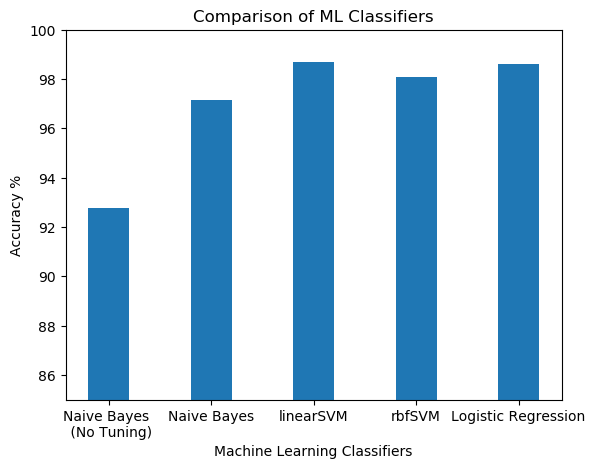

In [161]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
classifers = ('Naive Bayes \n (No Tuning)', 'Naive Bayes', 'linearSVM', 'rbfSVM', 'Logistic Regression')
x = np.arange(len(classifers))

performance = [bad_charge_clf.score(cd_test, cc_test), nb_charge_clf.score(cd_test, cc_test), 
               svm_lin_charge_clf.score(cd_test, cc_test), svm_rbf_charge_clf.score(cd_test, cc_test),
               log_charge_clf.score(cd_test, cc_test)]
performance = [x*100 for x in performance]

plt.bar(x, performance, width=0.4, bottom=None, align='center', tick_label=classifers)
plt.xticks(x)
plt.ylim([85,100])
plt.ylabel('Accuracy %')
plt.xlabel('Machine Learning Classifiers')
plt.title('Comparison of ML Classifiers')

plt.show()
# plt.savefig('classifer_comparison.png', dpi=800)

# CONCLUSION

The models perform admirably, approaching 99% for the linearSVM and Logistic Regression.

The current goal is to use the classifier to create "filled tables" in their database with the following information:

1. Predicted Charge Class
2. Probability distribution for all charge classes, so someone viewing the table can make an informed decision about the classifier's performance in a given instance

The baseline goal is to achieve 99%. However, given this is a mixed classificaiton problem I believe optimizing precision and recall to 99% to be the ultimate goal. In this industry, it's very important to have high precision as to not misclassify a dangerous offense as something trivial or to misclassify something trivial as a more severe crime. Similar consequences would occur if we have poor recall.

I am confident this project will make a real world impact to the mentioned end users as the Recidiviz real-time US jails database gains more coverage and my ML charge classifier fills in the missing information with high confidence.

### Points of caution

1. How to handle what California nicknamed as "wobbler" offenses, or those that have a range of charge classifications (i.e. misdomeaner to felony)

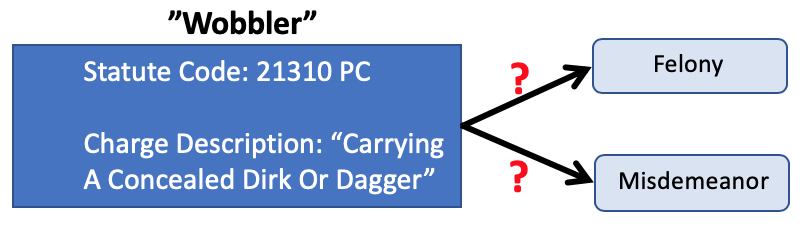

In [163]:
Image("images/wobbler_example.png", width=800, height=600)

2. Implementing the charge classifier in other states, with varying implementations of the law regarding charge classification. There are multiple different systems, some with more wiggle room for charge classification than others.

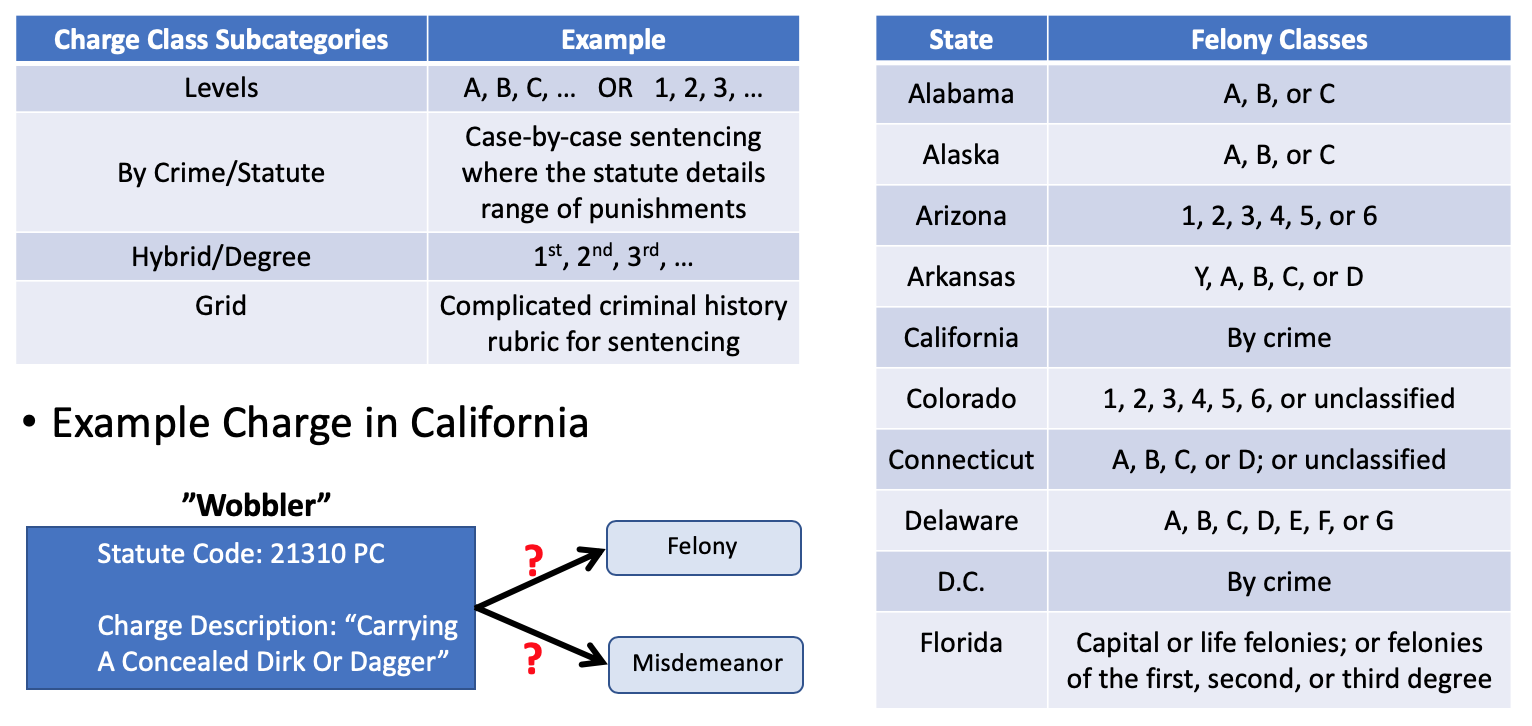

In [164]:
Image("images/state_law_charge_classifications.png", width=800, height=600)

### Next Steps

1. Better NLP to improve the ML classifier, which can only be as good as the word/phrase parsing/vectorizing allows it to be
    > 1. Future efforts to nail down specific syntax regarding state-by-state jail charge descriptions
    > 2. Tackle abbreviations (should be the same as the full word, unless it's common to say "veh" for one charge class and "vehicle" for another, for example
    > 3. Tackle typos (there are many different representations of self-similar words that have typos)
2. An ensemble model to improve ML classification:
    > 1. Use ensemble model with voting scheme for Naive Bayes, SVM and Logistic Regression
    > 2. Custom ensemble model, where if the softmax class probability of the first model is too close to other class probabilities, try classifiying the charge using an alternative model
3. Investigate weak-learner/boosting models (i.e. decision trees with adaboost)
    > Pros:
        > 1. Would be able to separate self-similar charge descriptions (such as the "TBUT..." example given previously), which may not be seperable by linear classification methods such as linearSVC or logistic regression, which perform better than Naive Bayes (not linear unless likelihood factors are from exponential families)
        
    > Cons:
        > 1. This is prone to over-fitting and thus poor predictions
4. Deep learning w/ a neural net
    > Possibly a bit overkill, but could also naturally learn non-linear decision boundaries for self-similar charge descriptions...complicated to build, but plan to investigate this as well.